In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import os

# 변경하고자 하는 새로운 디렉토리 경로
new_directory = '/content/drive/MyDrive'

# 디렉토리 위치 변경
os.chdir(new_directory)

# 변경된 디렉토리 경로 출력
print("Current directory:", os.getcwd())


Current directory: /content/drive/MyDrive


# 53. 모델 저장 및 읽어오기
- 모델이 가지는 매개변수를 외부 파일로 읽고 저장하고 다시 읽어 오는 기능
- 학습중인 모델의 스냅샷을 저장하거나 이미 학습된 매개변수를 읽어와서 추론만 수행

### 넘파이의 save , load 함수

In [82]:
import numpy as np

x = np.array([1,2,3])
np.save('test.npy', x)

x = np.load('test.npy')
print(x)

[1 2 3]


In [83]:
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
np.savez('test.npz', x1= x1 , x2 = x2)
arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


In [84]:
# 시험에 나올 수 도
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
data = {'x1':x1, 'x2':x2}
np.savez('test.npz', **data) # 별표 두 개를 붙여주면 딕셔너리가 자동으로 전개되어 전달
arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


### Layer 클래스의 매캐변수를 평평하게

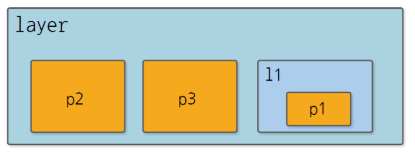

In [85]:
import dezero
from dezero.core import Parameter

class Layer:
  def _flatten_params(self, params_dict, parent_key=""):
    for name in self._params:
      obj = self.__dict__[name]
      key = parent_key + '/' + name if parent_key else name

      if isinstance(obj, Layer):
        obj._flatten_params(params_dict, key)
      else:
        params_dict[key] = obj


layer = Layer()
l1 = Layer()
l1.p1 = Parameter(np.array(1))
layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))

In [86]:
# Layer 클래스의 매개변수를 외부 파일로 저장
def save_weights(self, path):
  self.to_cpu()

  parmas_dict = {}
  self._flatten_params(params_dict)
  array_dict = {key: param.data for key, param in parms_dict.items()
                if param is not None}

  try:
    np.savez_compressed(path, **array_dict)
  except (Exception, KeyboardInterrupt) as e:
    if os.path.exixts(path):
      os.remove(path)
    raise

def load_weights(self, path):
  npz = np.load(path)
  params_dict = {}
  self._flatten_params(params_dict)
  for key. param in params_dict.items():
    param.data = npz[key]

### MNIST 학습으로 매개변수 저장과 읽기 기능

In [61]:
import os
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.datasets import MNIST

from dezero.models import MLP

In [ ]:
max_epoch = 3
batch_size =100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if os.path.exists('my_mlp.npz'):
  model.load_weights('my_mlp.npz')

In [ ]:
for epoch in range(max_epoch):
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(t)

  print('epoch: {}, loss:{:,4f}'.format(epoch + 1, sum_loss / len(train_set)))

model.save_weights('my_mlp.npz')

# 54. 드롭아웃과 테스트 모드
과대적합이 일어나는 주요원인
- 훈련데이터가 적음
- 모델의 표현력이 지나치게 높음

해결방안
- 데이터 확보
- 가중치 감소, 드롭아웃, 배치 정규화

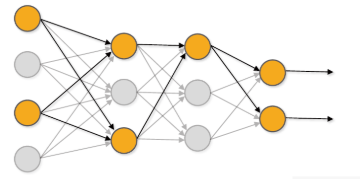

[드롭아웃]
- 뉴런을 임의로 삭제하면서 학습하는 방법
- 학습 시에는 은닉층 뉴런을 무작위로 골라 삭제
- 삭제된 뉴런은 신호를 전송하지 않음
- 학습 데이터를 흘려보낼 때마다 삭제할 뉴런을 무작위로 선택

In [87]:
import numpy as np
dropout_ratio = 0.6
x = np.ones(10)

mask = np.random.rand(10) > dropout_ratio
y = x * mask

In [88]:
# 학습시
mask = np.random.rand(10) > dropout_ratio
y = x * mask

# 테스트 시
scale = 1 - dropout_ratio # 학습시에 살아남은 뉴런의 비율
y = x * scale

[역 드롭아웃]
- 스케일을 맞추기를 학습할 때 수행
- 테스트 시 아무런 처리도 하지 않기 때문에 테스트 속도 향상

In [89]:
# 학습 시
scale = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scale

# 테스트 시
y = x

드롭아웃 테스트 모드 추가
- 역전파 비활성 모드

In [ ]:
class Config:
  enable_backprop = True
  train = True
@contextlib.contextmanager
def using_config(name, value):
  old_value = getattr(Config, name)
  setattr(Config, name, value)
  yield
  setattr(Config, name, old_value)

def test_mode():
  return using_config('train', Fasle)

In [91]:
# 드롭아웃 구현
def dropout(x, dropout_ratio=0.5):
  x= as_variable(x)

  if dezero.Config.train:
    xp = cuda.get_array_module(x)
    mask = xp.random.rand(*x.shape) > dropout_ratio
    scale = xp.array(1.0 - dropout_ratio).astype(x.dtype)
    y = x * mask / scale
    return y

  else:
    return x

In [92]:
from dezero import test_mode
import dezero.functions as F

x = np.ones(5)
print(x)

y = F.dropout(x)
print(y)

with test_mode():
  y = F.dropout(x)
  print(y)

[1. 1. 1. 1. 1.]
variable([2. 0. 0. 2. 0.])
variable([1. 1. 1. 1. 1.])


# 55. CNN 매커니즘
- 합성곱 신경망은 이미지 인식, 음성인식, 자연어 처리 등 다양한 분야에서 사용
- 이미지 인식용 딥러닝이라고 하면 대부분 CNN

- 첫 번째 합성곱 층의 뉴런은 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장
안에 있는 픽셀에만 연결
- 두 번째 합성곱 층에 있는 각 뉴런은 첫 번째 층의 작은 사각 영역 안에 위치한 뉴런에 연결

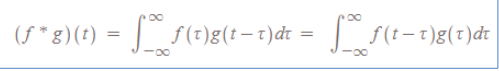

[CNN 구조]

Linear -> ReLU 연걸이 Conv -> ReLU -> POOL 로 대체

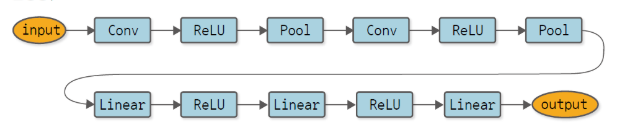

[합성곱 연산]
- CNN의 합성곱층에서 수행하는 연산
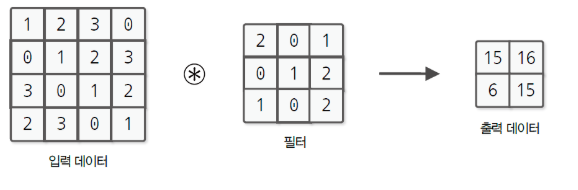

- 입력데이터에 대한 필터 윈도를 일정 간격으로 이동시키면서 적용
- 필터와 입력의 해당 원소를 곱하여 총합을 구하고 그결과를 해당 위치에 저장

[편향을 포함한 합성곱 연산의 처리 흐름]

▪ 합성곱층에도 편향이 존재함

▪ 편향은 필터링 후에 더해줌

▪ 편향은 하나뿐이라는 점에 주의

▪ 하나의 똑같은 값이 필터 적용 후의 모든 원소에 브로드캐스트되어 더해짐


[패딩]
- 합성곱층의 주요 처리 전에 입력 데이터 주위에 고정값을 채움
- 정보손실을 방지하기 위해서 사용

[스트라이드]
- 필터를 적용하는 위치의 간격(보폭을 뜻함)

<출력 그키 계산>
- 패딩 크기를 늘리면 출력 데이터의 크기가 커짐
- 스트라이드를 늘리면 출력 데이터의 크기가 작아짐

In [93]:
def get_conv_outsize(input_size, kernel_size, stride, pad):
  return (input_size + pad * 2 - kernel_size) // stride + 1

H, W = 4, 4 # input size
KH, KW = 3,3 # Kernel size
SH, SW = 1,1 # Kernel size
PH, PW = 1,1 # Padding size

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


## 3차원 텐서
- 3차원 텐서의 합성곱 연산
- 깊이 방향으로 데이터가 늘어난 것을 제외하면 필터가 움직이는 방법도 계산도 같음
- 입력 데이터와 필터의 채널 수를 똑같이 맞춰줘야 함
- 필터의 가로, 세로 크기는 원하는 숫자로 설정
- 2차원 합성곱 연산은 대부분 Conv2d라는 이름을 제공

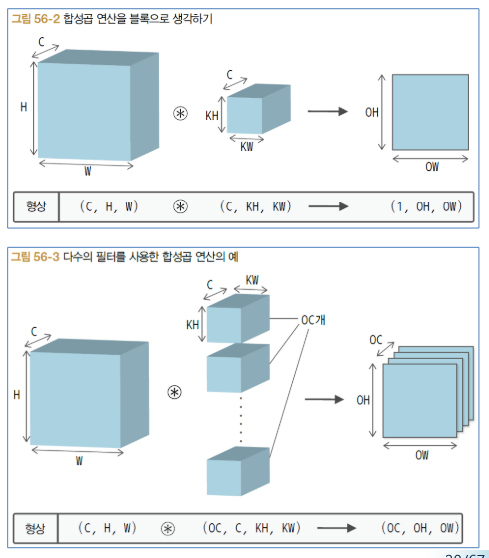

[합성곱 연산을 블록으로 표현]
- 데이터가 (채널(Channel), 높이(Height),
너비(Width)) 순서로 정렬
- 데이터의 형상은 (C, H, W)로 표기
필터는 (C, KH, KW) 라고 표기
- 출력은 특징 맵
- 특징 맵을 채널 방향으로 여러 장
갖으려면 다수의 필터를 사용
- OC** 개의 필터를 개별적으로 적용
- 출력의 특징 맵도 OC개가 생성됨
- OC개의 맵을 모아 (OC, OH, OW)
형상의 블록을 만듬

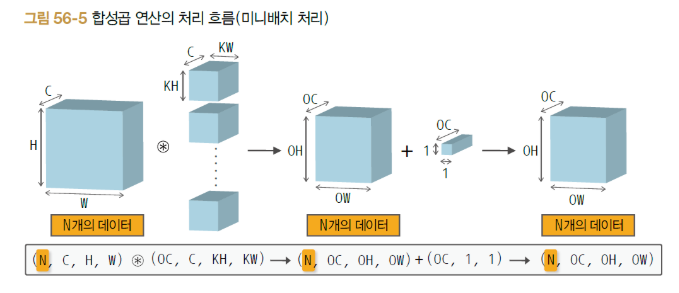

[합성곱 연산의 미니 배치 처리]
▪ 미니배치 처리를 위해서는 각 층을 흐르는 데이터를 4차원 텐서로 취급함

▪ N 개의 데이터로 이루어진 미니배치 합성곱 연산 수행

▪ 데이터의 맨 앞에 배치를 위한 차원이 추가됨

▪ 데이터를 (batch_size, channel, height, width) 형상으로 정렬

▪ 4차원 텐서의 샘플 데이터 각각에 대해 (독립적으로) 똑같은 합성곱 연산을 수행함

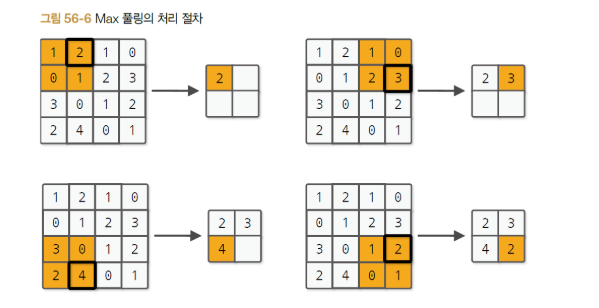

[풀링층]

▪ 풀링은 가로, 세로 공간을 작게 만드는 연산임

▪ Max 풀링(최대 풀링)은 최댓값을 취하는 연산이며, 2 x 2 는 대상 영역의 크기를 나타냄

▪ 2 x 2 영역에서 값이 가장 큰 원소를 찾는 것임

▪ 일반적으로 풀잉 윈도 크기와 스트라이드 크기는 같은 값으로 설정함

[풀링층의 주요 특징]

▪ 학습하는 매개변수가 없다
- 대상 영역에서 최댓값(or 평균값) 처리만 하면 끝임
▪ 채널 수가 변하지 않는다
- 계산이 독립적으로 이루어짐

▪ 미세한 위치 변화에 영향을 덜 받는다
-  입력 데이터의 차이가 크지 않으면 풀링 결과가 크게 달라지지 않음
- 입력 데이터의 미세한 차이에 강건함